In [124]:
import pandas as pd
from fredapi import Fred
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [125]:
fred=Fred(api_key="709596a84b6fac52bb342d0f8ec0c168")

In [126]:
indicators = {
    'gdp': 'GDPC1',                   # Real GDP
    'interest_rate': 'FEDFUNDS',     # Fed Funds Rate
    'unemployment': 'UNRATE',        # Unemployment Rate
    'cpi': 'CPIAUCSL',                # Consumer Price Index for All Urban Consumers
    'pce': 'PCEPI',                   # Personal Consumption Expenditures Price Index
    'nonfarm_payrolls': 'PAYEMS',    # Nonfarm Payrolls
    'corporate_profits': 'CP',       # Corporate Profits After Tax
    'money_supply': 'M2SL',          # M2 Money Stock
    'consumer_confidence': 'UMCSENT',# University of Michigan: Consumer Sentiment
    'housing_starts': 'HOUST',       # Housing Starts
    'permits': 'PERMIT'              # New Building Permits
}

In [127]:
macro_data=pd.DataFrame({key: fred.get_series(value, observation_start='2010-01-01') for key, value in indicators.items()})

In [128]:
macro_data=macro_data.shift(1)

In [129]:
key_ind=['interest_rate', 'unemployment', 'cpi', 'pce']

In [130]:
for ind in key_ind:
    macro_data[f"{ind}_lag1"]=macro_data[ind].shift(1)

rolling_features = ['interest_rate', 'cpi']
for col in rolling_features:
    macro_data[f'{col}_roll3_mean'] = macro_data[col].rolling(window=3).mean()
    macro_data[f'{col}_roll3_std'] = macro_data[col].rolling(window=3).std()

In [131]:
q_columns=['gdp','corporate_profits']

macro_data[q_columns] = np.round(macro_data[q_columns].interpolate(method='linear'),0)

[*********************100%***********************]  1 of 1 completed

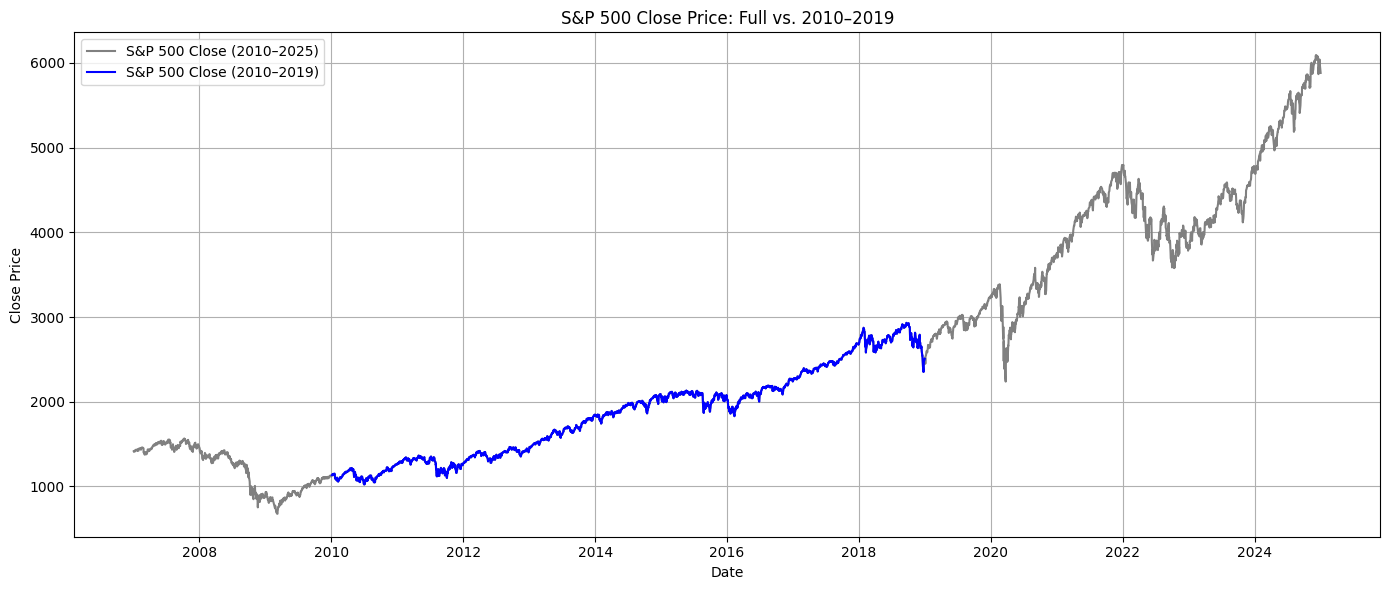

In [132]:
sp500 = yf.download("^GSPC", start="2007-01-01", end="2025-01-01")

# Podział danych na dwa zakresy
full_range = sp500['Close']
sub_range = sp500.loc["2010-01-01":"2019-01-01", 'Close']

# Wykres
plt.figure(figsize=(14, 6))
plt.plot(full_range, label='S&P 500 Close (2010–2025)', color='gray')
plt.plot(sub_range, label='S&P 500 Close (2010–2019)', color='blue')

plt.title('S&P 500 Close Price: Full vs. 2010–2019')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [133]:
sp500 = yf.download("^GSPC", start="2010-01-01", end="2025-01-01")

# Obliczamy dzienne zwroty na bazie 'Close'
sp500['Return'] = sp500['Close'].pct_change()

sp500['LogReturn'] = sp500['Close']
#sp500['LogReturn'] = np.log(sp500['Close'].shift(-5) / sp500['Close'])
#sp500.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [134]:
sp500.columns = ['_'.join(filter(None, col)).strip() for col in sp500.columns.values]

In [135]:
sp500.columns

Index(['Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Volume_^GSPC',
       'Return', 'LogReturn'],
      dtype='object')

In [136]:
sp500['log_volume'] = np.log(sp500['Volume_^GSPC'].replace(0, np.nan))
sp500['ma_log_volume'] = sp500['log_volume'].shift(1).rolling(window=20, min_periods=1).mean()
sp500['prev_day_volume'] = sp500['Volume_^GSPC'].shift(1)

In [137]:

sp500.drop(['Close_^GSPC','High_^GSPC','Low_^GSPC','Open_^GSPC','Volume_^GSPC','Return'],axis=1,inplace=True)

In [138]:
sp500['month'] = sp500.index.to_period('M')
sp500['date'] = sp500.index
macro_data['month'] = macro_data.index.to_period('M')

In [139]:
sp500 = sp500.merge(macro_data, on='month', how='left')

In [140]:
sp500['interest_x_cpi'] = sp500['interest_rate'] * sp500['cpi']
sp500['unemp_x_gdp'] = sp500['unemployment'] * sp500['gdp']

In [141]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   LogReturn                 3774 non-null   float64       
 1   log_volume                3774 non-null   float64       
 2   ma_log_volume             3773 non-null   float64       
 3   prev_day_volume           3773 non-null   float64       
 4   month                     3774 non-null   period[M]     
 5   date                      3774 non-null   datetime64[ns]
 6   gdp                       3755 non-null   float64       
 7   interest_rate             3755 non-null   float64       
 8   unemployment              3755 non-null   float64       
 9   cpi                       3755 non-null   float64       
 10  pce                       3755 non-null   float64       
 11  nonfarm_payrolls          3755 non-null   float64       
 12  corporate_profits   

In [142]:
sp500.to_csv("data_preped.csv",index=False)